In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
import model_utils
from scipy.stats import dirichlet

In [2]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
        else:
            thetaarray[j] = theta
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

### Optimization of players

#### Probability functions of points scoring

In [3]:
def prob_clean_sheet_for_team(lambda_2):
    return(poisson.pmf(0, lambda_2))

def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def prob_mins_played(x, a, b, a_games):
    return((1 - poisson.cdf(x, a / b)) * np.round(a_games))  # a / b mean of gamma hyperparameter distribution

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n):
    d = np.random.dirichlet(np.array([a, b, c]))
    samples = np.random.choice(np.array([0, 1, 2]), n, p=d)
    return(sum(samples == 0), sum(samples == 1))

def prob_clean_sheet_points(lambda_2, a_mins, b_mins, a_games):
    return(prob_mins_played(60, a_mins, b_mins, a_games) * prob_clean_sheet_for_team(lambda_2))

def prob_mins_points(a_mins, b_mins, a_games):
    return(prob_mins_played(60, a_mins, b_mins, a_games) + prob_mins_played(1, a_mins, b_mins, a_games))

def sample_clean_sheet_points(lambda_2, a_mins, b_mins, a_games, b_games):
    return(int(sample_mins_played(a_mins, b_mins, a_games, b_games) > (60)) * sample_clean_sheet_for_team(lambda_2))

def sample_mins_points(a_mins, b_mins, a_games, b_games):
    return(int(sample_mins_played(a_mins, b_mins, a_games, b_games) > (60)) + int(sample_mins_played(a_mins, b_mins, a_games, b_games) > (1)))

In [4]:
def ComputeExpectedPoints(fixtures_list, form, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):

        # sample lambdas for team performance - sample from team hyperparameters
        lambdas = predict_fixtures(fixtures_list, form, teams, mu, a, d, alpha, uncertainty=True)

        for i in range(len(all_players_params.index)):  # sample performance of teams from poisson model, and players also 
            h_games = np.where(fixtures_list[:, 0] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            a_games = np.where(fixtures_list[:, 1] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            if (len(h_games) > 0 or len(a_games) > 0):  # players in championship wont get any points this season!
                if all_players_params.loc[all_players_params.index[i], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                for k in range(len(h_games)):  # over all home games
                    n = np.random.poisson(lambdas[0][h_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    points[l, i] += ((scaling[2] * sample_clean_sheet_points(lambdas[1][h_games[k]], all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])) +
                                           (sample_mins_points(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])))
                for k in range(len(a_games)):  # over all away games
                    n = np.random.poisson(lambdas[1][a_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    points[l, i] += ((scaling[2] * sample_clean_sheet_points(lambdas[0][a_games[k]], all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])) +
                                           (sample_mins_points(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])))

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)

    return(expected_points, sd_points)

### Historical fitting

In [5]:
form = np.ones((380, 2)) * 5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [6]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("../data/team_id_20192020.csv", header=1)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [8]:
C, S = ComputeExpectedPoints(fixture_list_this_season, form, teams, all_players_params, all_teams_params)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


---
Realisation  0
Top Points Scorers:  516    Christian Eriksen
276          Jamie Vardy
329      Raheem Sterling
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [166. 170. 170. 182. 216.]  points
---
Realisation  1
Top Points Scorers:  31     Pierre-Emerick Aubameyang
519                Heung-Min Son
134                  Eden Hazard
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [179. 184. 193. 209. 228.]  points
---
Realisation  2
Top Points Scorers:  310        Mohamed Salah
128    César Azpilicueta
306           Sadio Mané
134          Eden Hazard
329      Raheem Sterling
Name: player, dtype: object  with  [165. 173. 177. 203. 212.]  points
---
Realisation  3
Top Points Scorers:  134         Eden Hazard
306          Sadio Mané
329     Raheem Sterling
175    Luka Milivojevic
310       Mohamed Salah
Name: player, dtype: object  with  [169. 176. 176. 187. 211.]  points
---
Realisation  4
Top Po

---
Realisation  34
Top Points Scorers:  772    Alisson Ramses Becker
522               Harry Kane
339            Sergio Agüero
134              Eden Hazard
310            Mohamed Salah
Name: player, dtype: object  with  [176. 183. 190. 194. 215.]  points
---
Realisation  35
Top Points Scorers:  267      Harry Maguire
306         Sadio Mané
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [162. 177. 192. 206. 213.]  points
---
Realisation  36
Top Points Scorers:  339            Sergio Agüero
772    Alisson Ramses Becker
840             Raúl Jiménez
310            Mohamed Salah
329          Raheem Sterling
Name: player, dtype: object  with  [182. 186. 188. 245. 267.]  points
---
Realisation  37
Top Points Scorers:  337         Leroy Sané
315    Virgil van Dijk
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [168. 171. 185. 223. 253.]  points
---
Realisation  38
Top Points Score

---
Realisation  69
Top Points Scorers:  276        Jamie Vardy
306         Sadio Mané
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [171. 180. 193. 207. 242.]  points
---
Realisation  70
Top Points Scorers:  316    Andrew Robertson
134         Eden Hazard
330         David Silva
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [163. 165. 172. 178. 200.]  points
---
Realisation  71
Top Points Scorers:  516    Christian Eriksen
134          Eden Hazard
220     Gylfi Sigurdsson
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [174. 182. 183. 187. 235.]  points
---
Realisation  72
Top Points Scorers:  196     Jordan Pickford
175    Luka Milivojevic
134         Eden Hazard
339       Sergio Agüero
310       Mohamed Salah
Name: player, dtype: object  with  [171. 174. 190. 214. 217.]  points
---
Realisation  73
Top Points Scorers:  276          Jamie Vardy
306       

---
Realisation  103
Top Points Scorers:  130      Marcos Alonso
329    Raheem Sterling
310      Mohamed Salah
134        Eden Hazard
306         Sadio Mané
Name: player, dtype: object  with  [181. 185. 188. 191. 196.]  points
---
Realisation  104
Top Points Scorers:  563    Richarlison de Andrade
306                Sadio Mané
134               Eden Hazard
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [166. 178. 190. 192. 268.]  points
---
Realisation  105
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
220     Gylfi Sigurdsson
339        Sergio Agüero
310        Mohamed Salah
Name: player, dtype: object  with  [169. 171. 172. 202. 218.]  points
---
Realisation  106
Top Points Scorers:  306         Sadio Mané
522         Harry Kane
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [173. 175. 184. 193. 210.]  points
---
Realisation  107
Top Points Scorers:  840  

---
Realisation  137
Top Points Scorers:  329      Raheem Sterling
516    Christian Eriksen
134          Eden Hazard
840         Raúl Jiménez
310        Mohamed Salah
Name: player, dtype: object  with  [170. 172. 174. 185. 240.]  points
---
Realisation  138
Top Points Scorers:  330        David Silva
306         Sadio Mané
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [164. 168. 189. 195. 243.]  points
---
Realisation  139
Top Points Scorers:  315    Virgil van Dijk
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
306         Sadio Mané
Name: player, dtype: object  with  [180. 183. 214. 217. 218.]  points
---
Realisation  140
Top Points Scorers:  276          Jamie Vardy
306           Sadio Mané
329      Raheem Sterling
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [164. 166. 189. 195. 208.]  points
---
Realisation  141
Top Points Scorers:  522       Harry Kane
840     R

---
Realisation  172
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
134                      Eden Hazard
329                  Raheem Sterling
310                    Mohamed Salah
Name: player, dtype: object  with  [170. 170. 173. 179. 210.]  points
---
Realisation  173
Top Points Scorers:  372                       Paul Pogba
817    Felipe Anderson Pereira Gomes
99                   James Tarkowski
306                       Sadio Mané
310                    Mohamed Salah
Name: player, dtype: object  with  [166. 170. 175. 178. 274.]  points
---
Realisation  174
Top Points Scorers:  516    Christian Eriksen
134          Eden Hazard
306           Sadio Mané
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [166. 174. 178. 192. 228.]  points
---
Realisation  175
Top Points Scorers:  522             Harry Kane
516      Christian Eriksen
22     Alexandre Lacazette
329        Raheem Sterling
310          Mohame

---
Realisation  205
Top Points Scorers:  840       Raúl Jiménez
522         Harry Kane
828       Matt Doherty
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [163. 172. 173. 187. 229.]  points
---
Realisation  206
Top Points Scorers:  516    Christian Eriksen
128    César Azpilicueta
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [171. 173. 207. 217. 265.]  points
---
Realisation  207
Top Points Scorers:  306           Sadio Mané
516    Christian Eriksen
329      Raheem Sterling
339        Sergio Agüero
310        Mohamed Salah
Name: player, dtype: object  with  [170. 175. 179. 179. 218.]  points
---
Realisation  208
Top Points Scorers:  519                Heung-Min Son
322    Ederson Santana de Moraes
339                Sergio Agüero
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [169. 169. 185. 186. 199.]  points
---
Realisation  209
T

---
Realisation  240
Top Points Scorers:  128    César Azpilicueta
516    Christian Eriksen
134          Eden Hazard
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [170. 175. 197. 218. 229.]  points
---
Realisation  241
Top Points Scorers:  306           Sadio Mané
128    César Azpilicueta
329      Raheem Sterling
130        Marcos Alonso
310        Mohamed Salah
Name: player, dtype: object  with  [177. 180. 183. 184. 245.]  points
---
Realisation  242
Top Points Scorers:  516    Christian Eriksen
372           Paul Pogba
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [177. 178. 194. 241. 242.]  points
---
Realisation  243
Top Points Scorers:  516    Christian Eriksen
339        Sergio Agüero
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [170. 171. 179. 219. 234.]  points
---
Realisation  244
Top Points Scorers:  130       

In [9]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)

In [11]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [12]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,41.8,3,Mohamed Salah,MID,Liverpool,227.844,26.052786,175.738428,279.949572
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,54.9,3,Raheem Sterling,MID,Man City,188.676,22.323688,144.028625,233.323375
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,33.8,3,Eden Hazard,MID,Chelsea,173.328,21.717376,129.893248,216.762752
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,54.1,3,Sadio Mané,MID,Liverpool,164.192,21.102302,121.987397,206.396603
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,58.8,3,César Azpilicueta,DEF,Chelsea,155.656,16.280837,123.094325,188.217675
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,42.7,3,Christian Eriksen,MID,Tottenham,153.492,18.512318,116.467363,190.516637
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,38.2,3,Harry Kane,FWD,Tottenham,149.252,20.544306,108.163389,190.340611
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,32.5,3,Matt Doherty,DEF,Wolves,147.952,16.542240,114.867520,181.036480
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,147.868,12.485615,122.896770,172.839230
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,26.2,3,Jamie Vardy,FWD,Leicester,146.560,17.985060,110.589879,182.530121


In [13]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,147.868,12.485615,122.896770,172.839230
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,93.0,3,Alisson Ramses Becker,GKP,Liverpool,141.980,14.103461,113.773079,170.186921
775,775,20.0,1.0,1755.0,1.0,1.0,22.0,82.5,3,David de Gea,GKP,Man United,127.648,12.809219,102.029562,153.266438
710,710,19.5,1.0,1665.0,1.5,1.0,21.5,80.5,3,Kepa Arrizabalaga,GKP,Chelsea,127.588,13.409633,100.768734,154.407266
196,196,32.2,1.0,2781.0,0.2,1.0,34.2,89.1,3,Jordan Pickford,GKP,Everton,123.656,13.476263,96.703474,150.608526
506,506,28.3,1.0,2502.0,4.1,1.0,30.3,104.0,3,Hugo Lloris,GKP,Tottenham,122.884,12.072719,98.738562,147.029438
844,844,19.5,1.0,1710.0,1.5,1.0,21.5,73.0,3,Rui Pedro dos Santos Patrício,GKP,Wolves,120.756,12.499619,95.756763,145.755237
474,474,31.7,1.0,2781.0,0.7,1.0,33.7,84.8,3,Lukasz Fabianski,GKP,West Ham,111.724,11.216052,89.291896,134.156104
259,259,30.2,1.0,2644.5,2.2,1.0,32.2,89.3,3,Kasper Schmeichel,GKP,Leicester,111.684,11.522853,88.638294,134.729706
578,578,31.4,1.0,2754.0,1.0,1.0,33.4,85.4,3,Ben Foster,GKP,Watford,110.388,11.392166,87.603667,133.172333


In [14]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,58.8,3,César Azpilicueta,DEF,Chelsea,155.656,16.280837,123.094325,188.217675
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,32.5,3,Matt Doherty,DEF,Wolves,147.952,16.542240,114.867520,181.036480
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,57.0,3,Marcos Alonso,DEF,Chelsea,146.268,18.497464,109.273072,183.262928
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,78.0,3,Virgil van Dijk,DEF,Liverpool,145.016,16.194312,112.627376,177.404624
316,316,26.4,1.3,2235.0,6.0,8.5,28.4,74.2,3,Andrew Robertson,DEF,Liverpool,140.732,15.611924,109.508152,171.955848
341,341,27.9,1.5,2268.2,4.5,3.3,29.9,88.6,3,Kyle Walker,DEF,Man City,138.576,15.687072,107.201856,169.950144
826,826,19.5,3.0,1629.0,1.5,1.0,21.5,36.0,3,Willy Boly,DEF,Wolves,136.452,17.645614,101.160772,171.743228
721,721,19.0,3.0,1527.0,2.0,3.5,21.0,37.0,3,Lucas Digne,DEF,Everton,135.476,16.161480,103.153041,167.798959
763,763,18.5,2.0,1606.5,2.5,5.0,20.5,34.0,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,131.896,16.564214,98.767572,165.024428
833,833,20.0,1.0,1755.0,1.0,1.0,22.0,38.0,3,Conor Coady,DEF,Wolves,127.856,12.613773,102.628454,153.083546


In [15]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,41.8,3,Mohamed Salah,MID,Liverpool,227.844,26.052786,175.738428,279.949572
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,54.9,3,Raheem Sterling,MID,Man City,188.676,22.323688,144.028625,233.323375
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,33.8,3,Eden Hazard,MID,Chelsea,173.328,21.717376,129.893248,216.762752
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,54.1,3,Sadio Mané,MID,Liverpool,164.192,21.102302,121.987397,206.396603
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,42.7,3,Christian Eriksen,MID,Tottenham,153.492,18.512318,116.467363,190.516637
372,372,27.4,9.3,2192.0,5.0,9.9,29.4,42.2,3,Paul Pogba,MID,Man United,144.692,19.561317,105.569365,183.814635
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,31.6,3,Luka Milivojevic,MID,Crystal Palace,143.436,17.439435,108.557129,178.314871
220,220,28.1,8.7,2283.1,4.3,5.2,30.1,32.2,3,Gylfi Sigurdsson,MID,Everton,138.664,17.429834,103.804333,173.523667
563,563,29.9,9.0,2221.1,2.5,4.9,31.9,32.2,3,Richarlison de Andrade,MID,Everton,138.588,16.479146,105.629708,171.546292
817,817,19.5,5.5,1567.5,1.5,4.0,21.5,23.0,3,Felipe Anderson Pereira Gomes,MID,West Ham,132.588,17.679657,97.228687,167.947313


In [16]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,38.2,3,Harry Kane,FWD,Tottenham,149.252,20.544306,108.163389,190.340611
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,26.2,3,Jamie Vardy,FWD,Leicester,146.560,17.985060,110.589879,182.530121
339,339,25.0,17.8,1861.5,7.4,8.3,27.0,57.3,3,Sergio Agüero,FWD,Man City,145.124,20.936777,103.250446,186.997554
840,840,20.0,7.5,1601.0,1.0,6.0,22.0,16.5,3,Raúl Jiménez,FWD,Wolves,141.620,16.920154,107.779693,175.460307
22,22,28.9,11.7,1952.6,3.5,8.5,30.9,40.2,3,Alexandre Lacazette,FWD,Arsenal,133.212,18.157947,96.896105,169.527895
31,31,22.9,15.0,1722.8,9.5,5.7,24.9,39.7,3,Pierre-Emerick Aubameyang,FWD,Arsenal,132.084,17.050189,97.983622,166.184378
311,311,29.6,11.5,2176.0,2.8,7.4,31.6,55.1,3,Roberto Firmino,FWD,Liverpool,130.476,16.541385,97.393230,163.558770
169,169,27.2,8.7,2328.2,5.2,8.6,29.2,26.9,3,Wilfried Zaha,FWD,Crystal Palace,127.520,16.167919,95.184162,159.855838
53,53,25.2,10.4,1903.3,7.2,7.6,27.2,30.0,3,Callum Wilson,FWD,Bournemouth,119.928,15.221131,89.485739,150.370261
592,592,28.3,8.6,2175.0,4.1,5.9,30.3,22.9,3,Salomón Rondón,FWD,Newcastle,119.120,14.737218,89.645564,148.594436


### Analysis

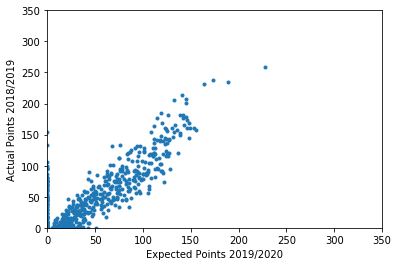

In [33]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = all_players_params.loc[all_players_params.index[ind], 'Expected Points 2019/2020']
    sd_points[i] = all_players_params.loc[all_players_params.index[ind], 'Std Points 2019/2020']

plot.errorbar(exp_points, y3['total_points'], marker='.', linestyle="")#, yerr=2 * sd_points, marker='.', linestyle="")
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2019/2020')
plot.ylabel('Actual Points 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, form, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))